# Predictions on growth of confirmed Novel Coronavirus (2019-nCoV) cases in countries 
                      By Bohan updated on April 27, 2020  
## Goal: Make an educated guess on when the spread of the novel coronavirus will stabilize (i.e. when the things will get better) in different countries

## Method: 
1. Use the data from China as an example to create logistic models for different countries 
2. Use R^2 to evaluate goodness of fit
3. Use inflection point to predict the turning point (i.e. when the number of newly confirmed cases per day will start to decrease)
4. Use 99.9% of the top horizontal asymptote value to predict when the situation wil stablize (i.e. the number of newly confirmed cases is closed to zero)

## Data: 
Publically available source from 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE  
https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv


## Disclaimer: 
### 1. The model assumes that everything stays constant, so the conclusions will be affected both positively and negatively by dramatic changes such as new travel restictions, shortage of health care supplies, ect
### 2. Only confirmed cases were included, so the result depends number of tests done and it does not necessarily reflect the actual infected population in each countries
### 3. I intend to update every week and conclusion may be different in each update (due to new models being generated from latest data)


## Summary: 
### 0. Update on the parameter boundary  for model
### 1. The logistic model was applied to 104 countries
### 2. Mean turning point for these countries is on 2020-04-11
(This is an understimate because only countries close to turning points can be modeled)
### 3. Mean CurveTop for these countries is on 2020-06-01
(This is also an understimate. If you check the graphs in the bottom, you will find that the numbers in some countires did not decrease as models predict )
### 4. The numbers of confirmed cases in some countires (such as  US, Italy, Spain, Canada) did not drop as predicted 
### 5. Comparing to last week, more countries can be modeled by logistic model. Mexico is prediced to exceed 80,000 cases 
### 6. From example graphs, there is no indication that the rate of increasing will drop soon as model prediction. 
It could be due to increased number of tests done but it also proves that the models tend to underestimate the situation.
### 7. The earliset time for situation in most countries to be stablized is in the begining of June 
  

In [1]:
import numpy as np;  # useful for many scientific computing in Python
import pandas as pd; # primary data structure library
import scipy as sp; # for statistical tests
import matplotlib.pyplot as plt; # for plotting
import seaborn as sns; # for heatmaps

# add custom converters for timestamps when plotting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
# data from 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE
# https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'); # import file
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,906,933,996,1026,1092,1176,1279,1351,1463,1531
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,539,548,562,584,609,634,663,678,712,726
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,2418,2534,2629,2718,2811,2910,3007,3127,3256,3382
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,696,704,713,717,717,723,723,731,738,738
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,24,24,24,24,25,25,25,25,26


## Create China data frame as an example
The location data and Province/State data will be ignore 

In [3]:
China = df[df['Country/Region'] == 'China'];
China.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20
49,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,...,991,991,991,991,991,991,991,991,991,991
50,Beijing,China,40.1824,116.4142,14,22,36,41,68,80,...,593,593,593,593,593,593,593,593,593,593
51,Chongqing,China,30.0572,107.8740,6,9,27,57,75,110,...,579,579,579,579,579,579,579,579,579,579
52,Fujian,China,26.0789,117.9874,1,5,10,18,35,59,...,354,355,355,355,355,355,355,355,355,355
53,Gansu,China,37.8099,101.0583,0,2,2,4,7,14,...,139,139,139,139,139,139,139,139,139,139


In [4]:
# calculate sums for the entire country
China_sum = China.iloc[:,4:].sum(axis=0);

## Create logistic model as
## f(x) = a / (1 + e^(-c * (x - d)) ) + b
    where x is time, 
    f(x) is Percentage confirmed cases over entire population,
    a,b,c,d are fitting parameters
    c > 0 (update on April 21, because if c<0, the top horizontal asymptote is b)

### The inflection point is at x =  -ln( abs(1 - 2a/(a-b) )) / c +d
### The top horizontal asymptote is f(x) = a + b

In [5]:
# create logistic function
def func(x, a,b,c,d): 
    return a / (1. + np.exp(-1.*c * (x - d))) + b

In [6]:
 # import curve_fit function and fit the curve
from scipy.optimize import curve_fit;
# repeate fitting three time using consecutive parameters
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=[China_sum.iloc[-1], 0,  1,  0],
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=popt,
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
popt, pcov = curve_fit(func, np.arange(len(China_sum)), China_sum.to_numpy(), p0=popt,
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
y_fit = func(np.arange(len(China_sum)), popt[0],popt[1],popt[2],popt[3]);

In [7]:
# create a function to plot data
def p_model(s, y_fit, name, fst):
    # s: pandas series containing number of confirmed cases
    # y_fit: 1-d array containing model data 
    # name: name of country (str)
    # fst: first day of the data set (str)
    
    plt.figure(figsize=(20,15));
    plt.plot(pd.to_datetime(fst)+pd.to_timedelta(np.arange(len(s)), unit='day'), s.to_numpy(),'b', label=name);
    plt.plot(pd.to_datetime(fst)+pd.to_timedelta(np.arange(len(y_fit)), unit='day'), y_fit,'r--', label='Simulated');
    plt.legend(fontsize=20);
    plt.ylabel('Number of confirmed cases', fontsize=20);
    plt.title('Cumulative number of confirmed cases', fontsize=20);
    plt.xlabel('Date', fontsize=20);
    plt.show();

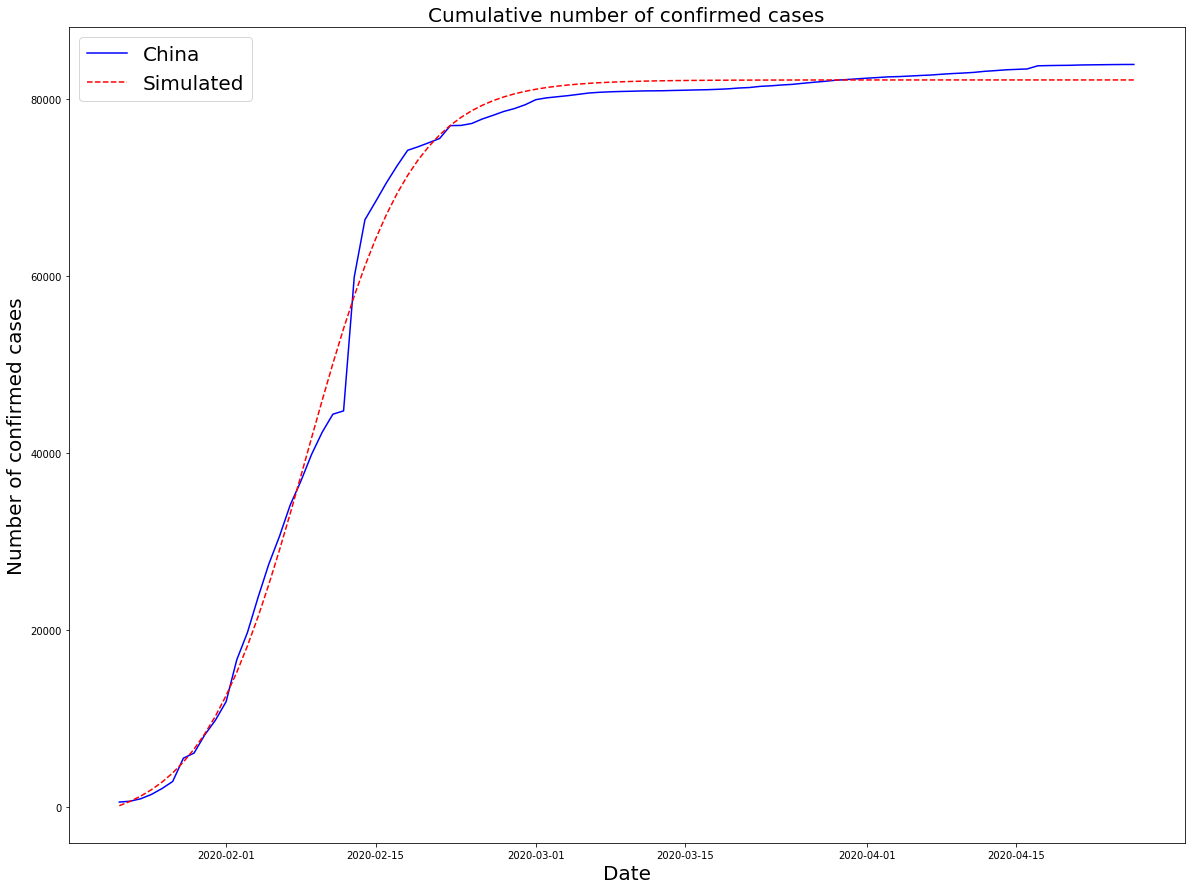

In [8]:
# plot for China
p_model(China_sum, y_fit, 'China', China_sum.index[0])

In [9]:
# define the function to caculate R^2 using residual sum of squares
def r_square(y, y_fit):
    # residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)

    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [10]:
# The closer the R^2 is to 1, the better the fitting
print('R^2 = ', r_square(China_sum.to_numpy(), y_fit))

R^2 =  0.9955045674863962


In [11]:
# find % when the confirmed population stablized on March 18
# the inflection point is at fp = a/2
# after solving for x in the logistic equation:
# x = -ln(abs(1-a/(fb-b)))/c + d = -ln(abs(1-2a/(a-b)))/c + d
# caculate this date:
iday = -np.log(abs(1-2*popt[0]/(popt[0]-popt[1])))/popt[2] + popt[3];
print('The day reaches the turning point is on: ',
      pd.to_datetime(China_sum.index[0]) + pd.to_timedelta(iday, unit='day'));

The day reaches the turning point is on:  2020-02-08 20:34:37.547155200


In [12]:
# top horizontal horizontal asymptotes is a + b (popt[0] + popt[1])
# time to reach 99.9% of asymptote is at y_hor = 0.999*(a + b)
# after solving for x in the logistic equation:
# x = -ln(abs(1-a/(y_hor-b)))/c + d
# caculate this date:
dday = -np.log(abs(1-popt[0]/(0.999*(popt[0]+popt[1])-popt[1])))/popt[2] + popt[3];
print('The day reaches the top of the curve is on: ',
      pd.to_datetime(China_sum.index[0]) + pd.to_timedelta(dday, unit='day'));
print('The total number of confirmed cases is ', popt[0]+popt[1]);

The day reaches the top of the curve is on:  2020-03-13 12:43:12.258854400
The total number of confirmed cases is  82162.17959021572


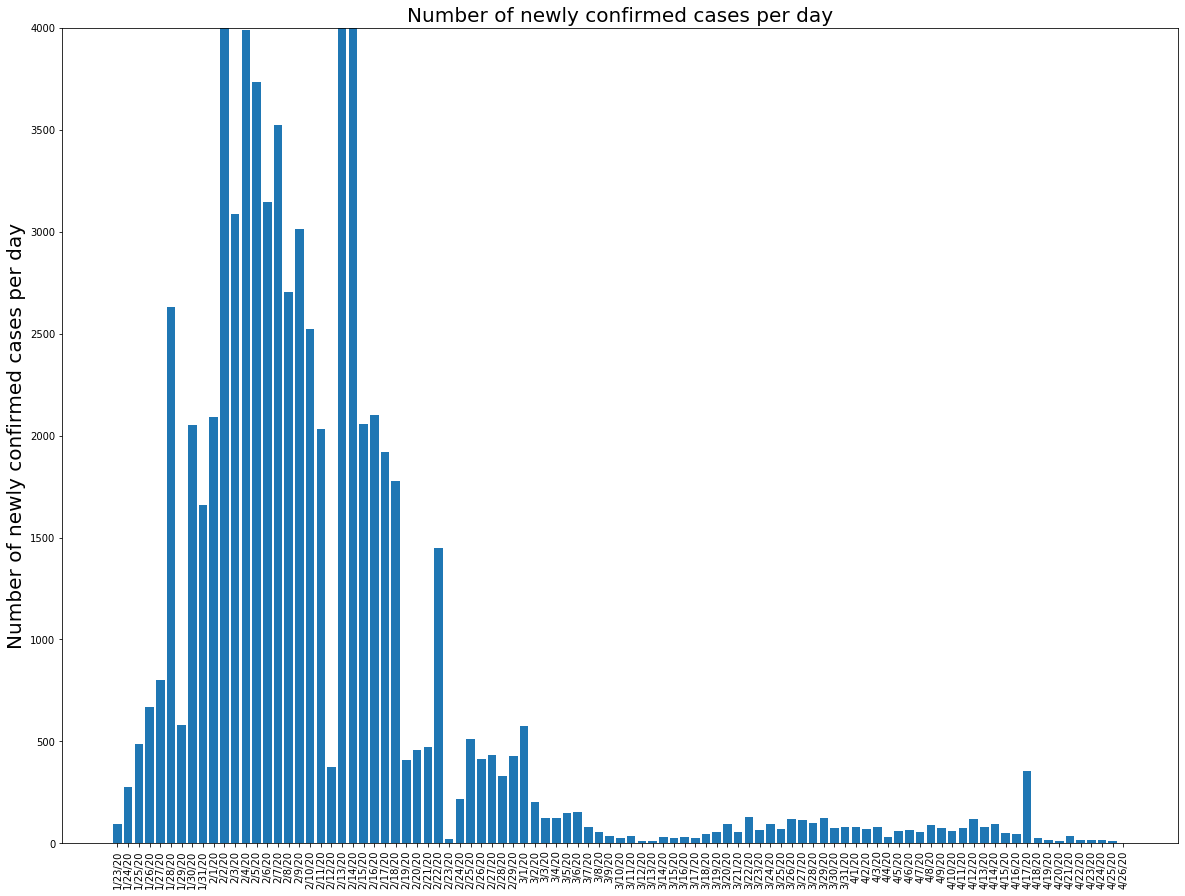

In [13]:
# plot number of newly confirmed cases
plt.figure(figsize=(20,15));
plt.bar(China_sum.index[1:], China_sum.to_numpy()[1:]-China_sum.to_numpy()[:-1]);
plt.xticks(rotation='vertical');
plt.ylim((0,4000));
plt.ylabel('Number of newly confirmed cases per day', fontsize=20);
plt.title('Number of newly confirmed cases per day', fontsize=20);

## Summary:
1. As shown in the bar graph, the number of newly confirmed cases did decrease after 2/7/2020 as perdicted by the model but it increased again on 2/13/2020.
2. After 3/8/2020, the number of newly confirmed cases stablized which closely matches the modelperdiction: 3/11/2020.  
3. Therefore, the model is suitable for making guesses.

# Predictions on Other countries

In [14]:
# fitting parameters for China
popt_china = popt;
# for storing data
POPT = [];
PCOV = [];
R2 = [];
Iday = [];
Dday = [];
NAME = [];
TotalC = [];

# I will ignore number of confirmed cases below 400
# because good model cannot be generated from small sample size
countries = df['Country/Region'].unique()
for ct in np.arange(len(countries)):
    
    # caculate sums per country
    df1 = df[df['Country/Region'] == countries[ct]].iloc[:, 4:].sum(axis=0);
    
    # I will ignore number of confirmed cases below 400
    # because good model cannot be generated from small sample size
    if df1[-1] < 400:
        continue
    
    # try to fit the curve
    try:
        # repeate fitting three time starting with parameters for China
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), 
                               p0= [df1.iloc[-1], popt_china[1],popt_china[2],popt_china[3]], 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt, 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
        popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt, 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
    except RuntimeError:
        try: 
            # repeate fitting three time starting with zeros
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt, 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
            popt, pcov = curve_fit(func, np.arange(len(df1)), df1.to_numpy(), p0=popt, 
                      bounds=((-np.inf, -np.inf, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf)) );
        except RuntimeError:
            continue
    
    # calculate model curve
    y_fit = func(np.arange(len(df1)), popt[0],popt[1],popt[2],popt[3]);
    
    # calculate R^2
    # The closer the R^2 is to 1, the better the fitting
    r2 = r_square(df1.to_numpy(), y_fit);
    
    # ignore if R^2 value is less than 0.98 or above one (indeicating poor fits)
    if r2 < 0.98 or r2 > 1:
        continue
    
    # print country name
    print(countries[ct]);
        
    # print R^2
    print('R^2 = ', r2);
    
    # caculate turning point
    iday = -np.log(abs(1-2*popt[0]/(popt[0]-popt[1])))/popt[2] + popt[3];
    print('The day reaches the turning point is on: ',
          pd.to_datetime(df1.index[0]) + pd.to_timedelta(iday, unit='day'));
    
    # caculate date reaches mzx:
    dday = -np.log(abs(1-popt[0]/(0.999*(popt[0]+popt[1])-popt[1])))/popt[2] + popt[3];
    print('The day reaches the top of the curve is on: ',
          pd.to_datetime(df1.index[0]) + pd.to_timedelta(dday, unit='day'));
    print('The total number of confirmed cases is ', popt[0]+popt[1]);
    
    # save data
    POPT.append(popt);
    PCOV.append(pcov);
    R2.append(r2);
    Iday.append(pd.to_datetime(df1.index[0]) + pd.to_timedelta(iday, unit='day'));
    Dday.append(pd.to_datetime(df1.index[0]) + pd.to_timedelta(dday, unit='day'));
    TotalC.append(popt[0]+popt[1]);
    NAME.append(countries[ct]);
    
# convert to numpy array
POPT = np.array(POPT);
PCOV = np.array(PCOV);
R2 = np.array(R2);

Afghanistan
R^2 =  0.9977080644650089
The day reaches the turning point is on:  2020-04-22 02:34:06.726201600
The day reaches the top of the curve is on:  2020-06-23 18:39:00.689011200
The total number of confirmed cases is  2450.17196892654
Albania
R^2 =  0.9949050187667098
The day reaches the turning point is on:  2020-04-08 13:05:27.744259200
The day reaches the top of the curve is on:  2020-06-14 13:28:56.410636800
The total number of confirmed cases is  792.2471299400602
Algeria
R^2 =  0.9958894140112559
The day reaches the turning point is on:  2020-04-11 00:54:45.376156800
The day reaches the top of the curve is on:  2020-06-05 00:03:47.051164800
The total number of confirmed cases is  3678.0088128027724
Andorra
R^2 =  0.9973656537443252
The day reaches the turning point is on:  2020-03-31 04:03:57.926102400
The day reaches the top of the curve is on:  2020-05-10 01:33:32.698656
The total number of confirmed cases is  729.4300632040492
Argentina
R^2 =  0.9942050441834782
The day

C:\Users\erwin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Egypt
R^2 =  0.9994091506917945
The day reaches the turning point is on:  2020-04-21 05:25:48.446256
The day reaches the top of the curve is on:  2020-06-29 08:22:12.921974400
The total number of confirmed cases is  7195.959182903661
Estonia
R^2 =  0.9979591267300539
The day reaches the turning point is on:  2020-04-01 02:56:37.911091200
The day reaches the top of the curve is on:  2020-05-22 09:03:22.351046400
The total number of confirmed cases is  1656.244885049964
Finland
R^2 =  0.9982099459937694
The day reaches the turning point is on:  2020-04-09 10:10:00.990393600
The day reaches the top of the curve is on:  2020-06-12 06:52:29.527363200
The total number of confirmed cases is  5200.2025258152125
France
R^2 =  0.9959860788842604
The day reaches the turning point is on:  2020-04-08 01:55:50.778134400
The day reaches the top of the curve is on:  2020-05-30 13:06:55.633363200
The total number of confirmed cases is  183543.55175521303
Georgia
R^2 =  0.9981119503667024
The day reache

Netherlands
R^2 =  0.9982784713839935
The day reaches the turning point is on:  2020-04-07 11:05:33.813024
The day reaches the top of the curve is on:  2020-06-03 08:55:38.797680
The total number of confirmed cases is  40984.77606987073
New Zealand
R^2 =  0.9992515537288289
The day reaches the turning point is on:  2020-04-01 02:07:06.198211200
The day reaches the top of the curve is on:  2020-04-30 10:41:19.146854400
The total number of confirmed cases is  1450.4240089460834
Niger
R^2 =  0.998891145956806
The day reaches the turning point is on:  2020-04-08 00:26:18.014179200
The day reaches the top of the curve is on:  2020-04-30 18:12:09.445392
The total number of confirmed cases is  672.6850211257365
North Macedonia
R^2 =  0.9983366070100808
The day reaches the turning point is on:  2020-04-11 01:47:23.423942400
The day reaches the top of the curve is on:  2020-06-04 10:25:34.336588800
The total number of confirmed cases is  1595.7078118361705
Norway
R^2 =  0.9987022553337768
The d

In [15]:
print('Number of Countries: ', len(NAME));
Pred = pd.DataFrame(data = {'Country/Region': NAME, 'R^2': R2, 'TurningP': Iday, 'CurveTop': Dday, 'TotalConfirmed': TotalC})
Pred.sort_values(by=['TotalConfirmed'], ascending=False).style.bar(subset=['TotalConfirmed'])

Number of Countries:  104


,Country/Region,R^2,TurningP,CurveTop,TotalConfirmed
101,US,0.997767,2020-04-11 00:14:11.309308800,2020-05-30 22:53:22.954646400,1.0367e+06
80,Qatar,0.998373,2020-06-03 10:52:35.573059200,2020-08-18 08:25:21.655516800,348917
90,Spain,0.996595,2020-04-02 17:07:44.596790400,2020-05-21 12:25:28.658179200,220344
52,Italy,0.997336,2020-03-30 06:20:21.977664,2020-05-29 04:09:14.147078400,197551
36,France,0.995986,2020-04-08 01:55:50.778134400,2020-05-30 13:06:55.633363200,183544
99,United Kingdom,0.999043,2020-04-12 10:32:30.866064,2020-06-01 10:45:10.987516800,172400
38,Germany,0.998666,2020-04-01 05:59:52.160755200,2020-05-16 02:55:09.563980800,155421
82,Russia,0.999849,2020-04-23 14:40:51.617769600,2020-06-02 18:28:56.425382400,133860
96,Turkey,0.999222,2020-04-13 01:41:51.734342400,2020-05-25 23:07:43.219228800,122106
15,Brazil,0.997967,2020-04-25 09:40:14.290579200,2020-06-26 10:27:20.316384,118266


In [16]:
print('Mean turning point for these countries is ', Pred['TurningP'].mean());
print('Mean CurveTop for these countries is ', Pred['CurveTop'].mean());

Mean turning point for these countries is  2020-04-11 00:35:54.499427840
Mean CurveTop for these countries is  2020-06-01 23:52:42.674754560


## Examples

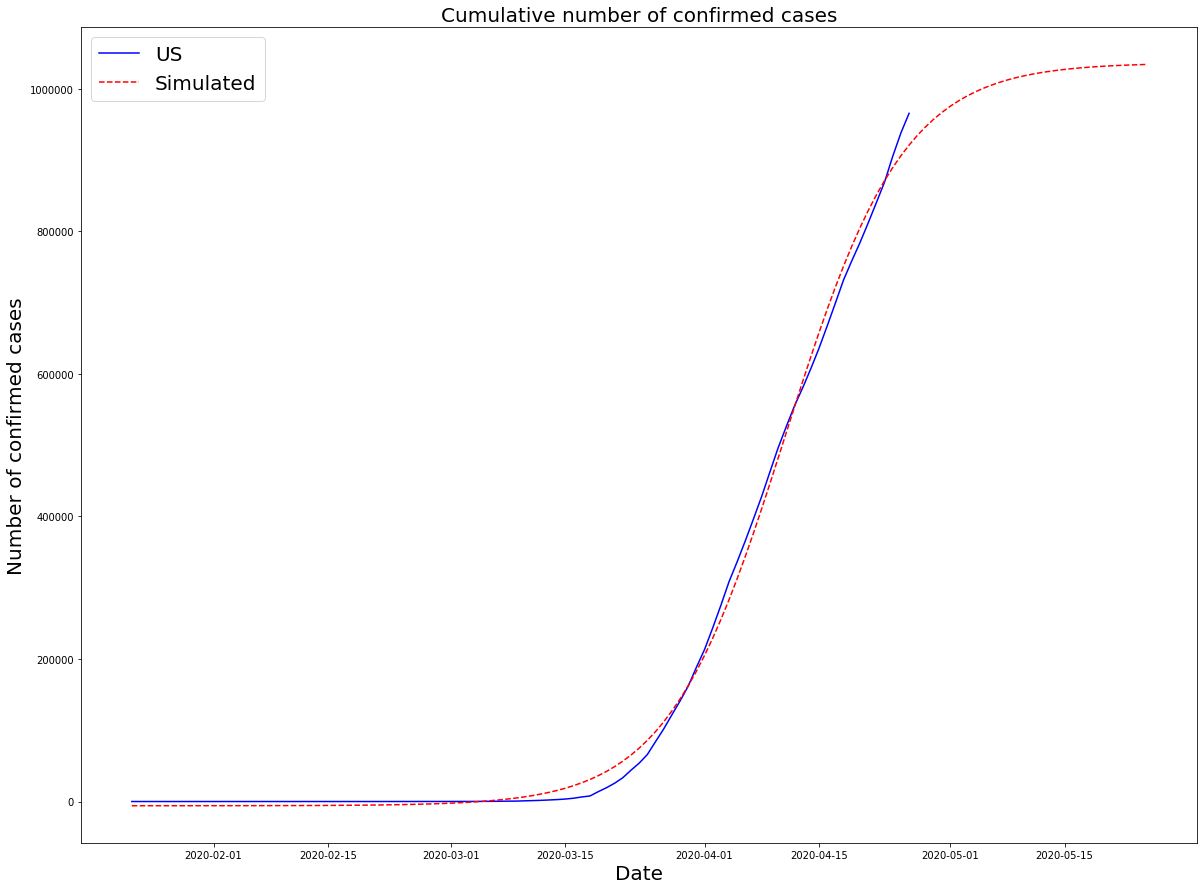

In [17]:
# US
example = 'US';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

In [18]:
popt2

array([[ 1.04263618e+06, -5.93489430e+03,  1.38176765e-01,
         7.99274621e+01]])

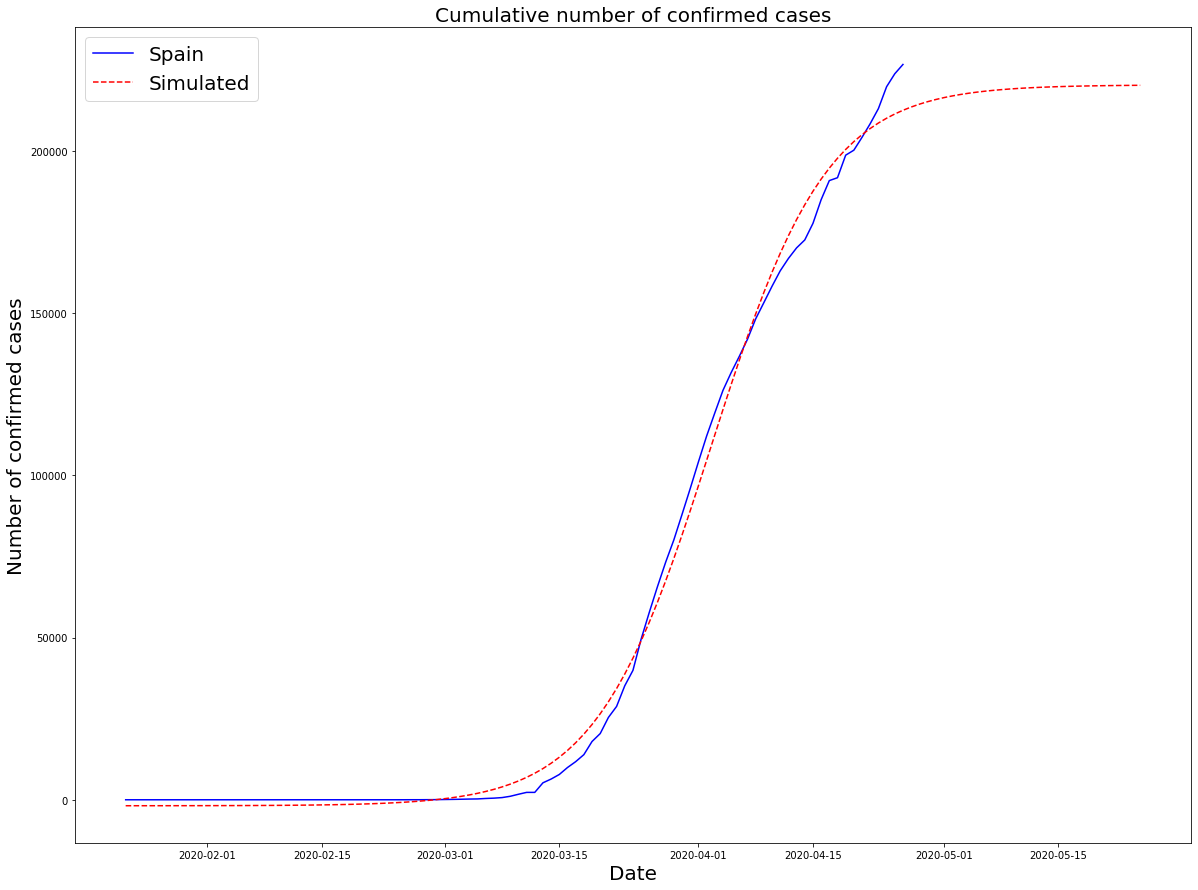

In [19]:
# Spain
example = 'Spain';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

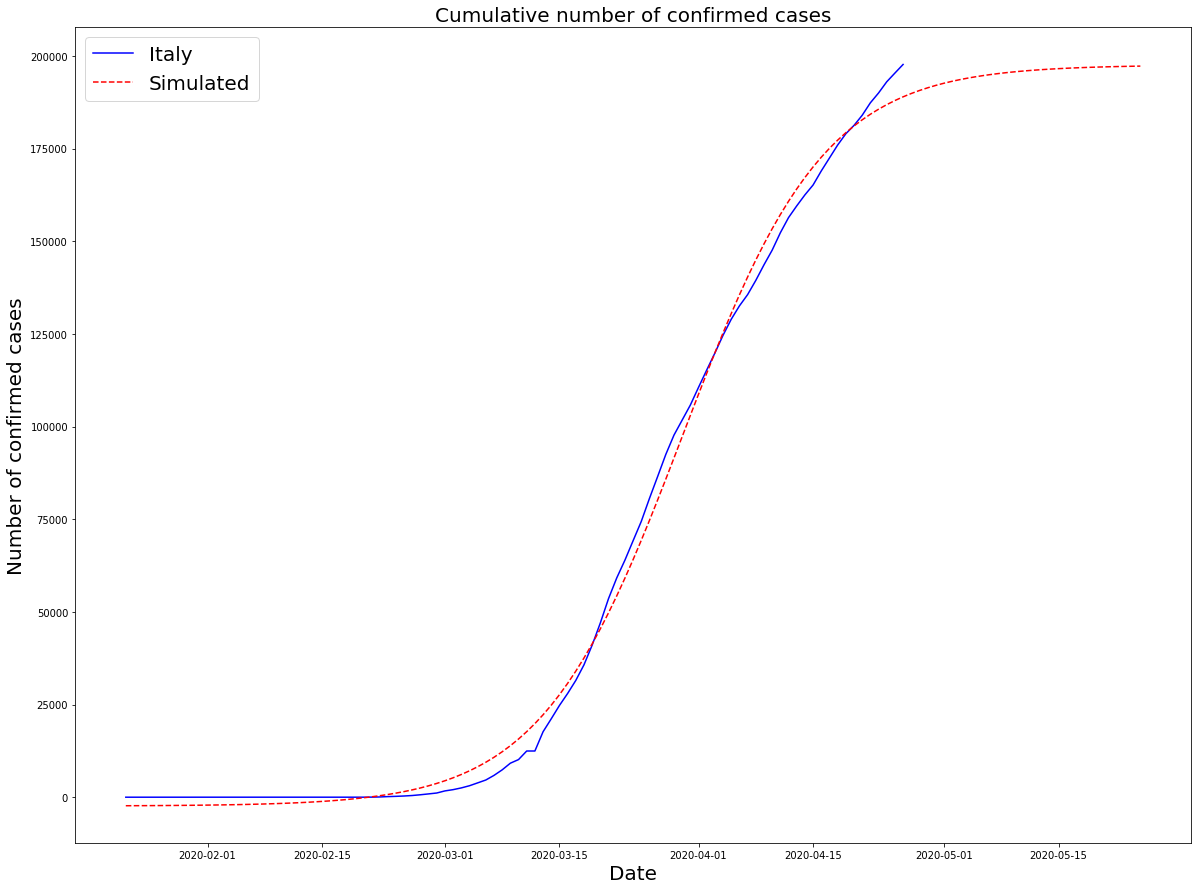

In [20]:
# Italy
example = 'Italy';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);

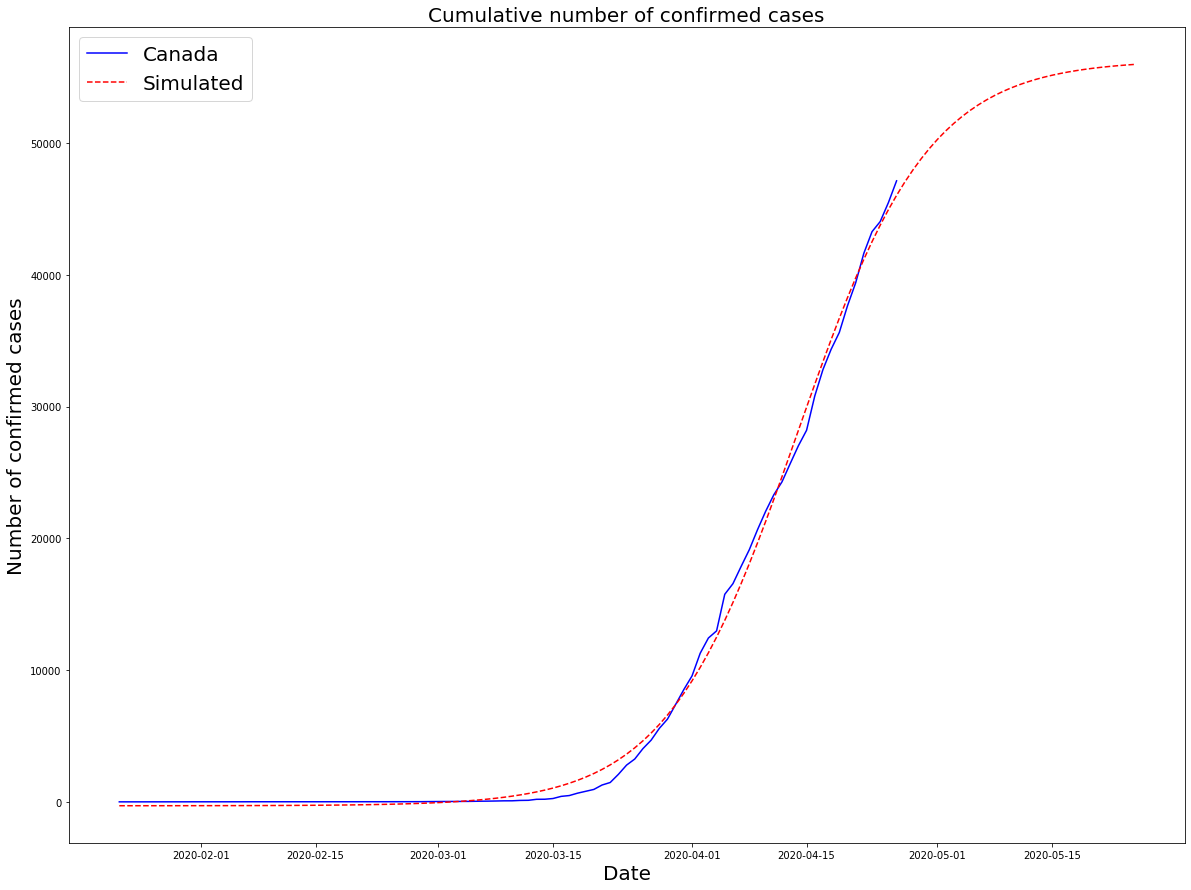

In [21]:
# Canada
example = 'Canada';
df2 = df[df['Country/Region'] == example].iloc[:, 4:].sum(axis=0);
popt2 = POPT[Pred.index[Pred['Country/Region'] == example], :];
y_fit2 = func(np.arange(len(df2)*1.3), popt2[0,0],popt2[0,1],popt2[0,2],popt2[0,3]);
p_model(df2, y_fit2, example, df2.index[0]);